In [1]:
import os
import sys
if '/home/zechengh/Mastik/ad/detector/' not in sys.path:
    sys.path.append('/home/zechengh/Mastik/ad/detector/')
from collections import OrderedDict
    
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import utils
import ADbenchmark
import LSTMAD

import json
import collections

import torch
from pathlib import Path

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

np.random.seed(0)
torch.manual_seed(0)

# Do not write .pyc
sys.dont_write_bytecode = True

# Reload code when code is changed
%load_ext autoreload
%autoreload 2

id_to_feature = utils.id_to_feature
for k, v in id_to_feature.items():
    print(k, v)

/home/zechengh/.local/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


0 Ins
1 L1D read access (# load)
2 L1D read miss
3 L1D write access (# store)
4 L1D write miss
5 L1D prefetch miss
6 L1I read miss
7 LLC read access
8 LLC read miss
9 LLC write access
10 LLC write miss
11 LLC prefetch access
12 LLC prefetch miss
13 DTLB read access
14 DTLB read miss
15 DTLB write access
16 DTLB write miss
17 ITLB read access
18 ITLB read miss
19 BPU read access
20 BPU read miss
21 Cache node read access
22 Cache node read miss
23 Cache node write access
24 Cache node write miss
25 Cache node prefetch access
26 Cache node prefetch miss
27 cycles
28 branch instructions
29 branch prediction miss
30 page faults
31 context switch
32 stall_during_issue
33 stall_during_retirement
34 Time stamp


In [2]:
id_to_feature = utils.id_to_feature
data = collections.defaultdict(collections.defaultdict)

for bg_program in ['none', 'mysql', 'webserver', 'streamserver', 'mltrain', 'mapreduce']:
    data_dir = 'perf/data/{bg_program}_same_core/10000us/'.format(bg_program=bg_program)
    for f in os.listdir(data_dir):
        if f.endswith('.npy'):
            file_name = f.split('.')[0]
            data[bg_program][file_name] = np.load(os.path.join(data_dir, f))

feature_list = utils.FeatureSelect.feature_list

print("Used features:")
for i in feature_list:
    print(id_to_feature[i])

Used features:
Ins
stall_during_issue
stall_during_retirement
cycles
L1D read access (# load)
DTLB read access
L1D write access (# store)
BPU read access
DTLB write access
branch instructions
L1D read miss
L1I read miss
context switch


In [3]:
models = {}
models['mysql'] = torch.load("detector/checkpoints/AnomalyDetectorMysql.ckpt")
models['streamserver'] = torch.load("detector/checkpoints/AnomalyDetectorSS.ckpt")
models['webserver'] = torch.load("detector/checkpoints/AnomalyDetectorWS.ckpt")
models['mltrain'] = torch.load("detector/checkpoints/AnomalyDetectorMLtrain.ckpt")
models['merged'] = torch.load("detector/checkpoints/AnomalyDetectorMerged.ckpt")

#### Calculate reconstruction errors (RED)

In [9]:
from pathlib import Path
import concurrent

model_name = 'merged'
model = models[model_name]
pred_errors = collections.defaultdict(collections.defaultdict)

for bg_program in data.keys(): 
    for file_name in data[bg_program].keys():
        
        data_in = model.normalize(np.float32(data[bg_program][file_name][:, feature_list]))
        data_in_tensor = torch.tensor(data_in)
        
        _, pred = model._get_reconstruction_error(
            data_in_tensor,
            gpu=True,
        )
        
        pred = pred[:, 0, :].detach().cpu().numpy()
        pred_errors[bg_program][file_name] = data_in[1:, :]-pred
        
        Path(f'detector/preprocessed/pred_errors/{model_name}/{bg_program}').mkdir(parents=True, exist_ok=True)
        np.save(f'detector/preprocessed/pred_errors/{model_name}/{bg_program}/{file_name}', pred_errors[bg_program][file_name])

#### Calculate kernel density of RED

In [10]:
from sklearn.neighbors import KernelDensity
import concurrent

sampling = True
training_data = []
testing_data = collections.defaultdict(list)

pred_errors = collections.defaultdict(collections.defaultdict)
model_name = 'merged'

for bg_program in ['none', 'mysql', 'webserver', 'streamserver', 'mltrain', 'mapreduce']:
    data_dir = f'detector/preprocessed/pred_errors/{model_name}/{bg_program}/'.format(bg_program=bg_program)
    for f in os.listdir(data_dir):
        if f.endswith('.npy'):
            file_name = f.split('.')[0]
            pred_errors[bg_program][file_name] = np.load(os.path.join(data_dir, f))

for bg_program in pred_errors.keys():
    d = pred_errors[bg_program]['ref_and_val_normal']
    if sampling:
        sampling_idx = np.random.randint(low=0, high=len(d), size=1000)
        d = d[sampling_idx, :]
        
    training_data.append(d)

training_data = np.concatenate(training_data, axis=0)

kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(training_data)
th = 5.0

for bg_program in pred_errors.keys():
    
    # Accelerate with multiprocessing
    def anomaly_detection(kde, data, bg_program, file_name):  
        kde_result = kde.score_samples(data)
        total = np.float32(len(kde_result))
        
        Path(f'detector/preprocessed/kde/{model_name}/{bg_program}').mkdir(parents=True, exist_ok=True)
        np.save(f'detector/preprocessed/kde/{model_name}/{bg_program}/{file_name}', kde_result)
        print(bg_program, file_name, kde_result)
        
        return 1
        
    executor = concurrent.futures.ProcessPoolExecutor(20)
    futures = [executor.submit(anomaly_detection, kde, pred_errors[bg_program][file_name], bg_program, file_name) for file_name in pred_errors[bg_program].keys()]
    concurrent.futures.wait(futures)

none test_abnormal_l3pp_with_gobmk [-12.32210329  -9.72702021  -8.83216454 ...  -7.51378641  -7.48302703
  -7.50702542]
none test_abnormal_spectrev4_with_gcc [-17.66458897 -11.32318118  -9.14070645 ...  -8.81173793  -8.81852762
  -8.82521275]
none test_abnormal_spectrev4_with_soplex [-9.08454352 -7.08576094 -6.5318151  ... -8.73687781 -8.73643311
 -8.73586664]
none test_normal_with_povray [-3.27205186 -3.18238816 -3.18383071 ... -3.36871268 -3.37082696
 -3.37294413]
none train_abnormal_spectrev3 [-171.89890832 -147.07401298 -138.03502318 ...  -93.53705856  -93.62920215
  -93.68351507]
none test_abnormal_fr_with_spec [ -9.46984148  -7.73435164  -6.80759687 ... -20.35743493 -20.51440409
 -20.5847393 ]
none test_abnormal_fr_with_gobmk [-10.89737872  -7.96216239  -7.08564369 ...  -5.93833574  -5.93433893
  -5.9356011 ]
none train_normal_with_milc [-11.78807047  -7.97005573  -6.79235293 ...  -3.6781189   -3.67810396
  -3.6781147 ]
none test_abnormal_spectrev1_with_gcc [-15.47387814 -11.5614

  -7.36571616]
 test_abnormal_spectrev3_with_mcf [ -82.73150124  -74.30837119  -72.02570205 ... -138.59659176 -138.09707593
 -137.95712146]
none train_normal_with_astar [-51.50903064 -39.14685183 -34.97380303 ...  -3.5954355   -3.59505586
  -3.59431362]
none test_abnormal_l3pp_with_gcc [-28.49797152 -19.55174582 -16.31714434 ... -15.77199682 -15.77348774
 -15.77591237]
none test_abnormal_ff [-20.92298323 -13.70283626 -11.19195066 ... -10.94912774 -10.94985094
 -10.94999842]
none test_abnormal_l1pp [-11.25833211  -8.81327582  -8.06383359 ...  -7.73194705  -7.73260242
  -7.73275021]
none test_abnormal_spectrev2 [-22.50967508 -13.62182575 -10.49225363 ...  -8.97328991  -8.97501332
  -8.97465178]
none test_abnormal_l1pp_with_gcc [-11.68951721  -9.16441598  -8.35796434 ...  -7.756386    -7.75655219
  -7.75682479]
none train_normal_with_soplex [-4.14510258 -3.74931587 -3.5474896  ... -3.1327665  -3.1327958
 -3.13285567]
none test_abnormal_ff_with_bzip2 [-9.72747928 -8.10184483 -7.60360001 ..

 -6.09082076]
mysql test_abnormal_l1pp_with_gpg [-6.57318889 -5.94624228 -5.62736567 ... -4.30585677 -4.30991754
 -4.3022045 ]
mysql test_abnormal_spectrev4_with_mcf [-19.34096002 -13.46748476 -11.44822424 ...  -4.26714513  -4.26747949
  -4.26600221]
mysql train_abnormal_l1pp [-7.43868732 -5.42494271 -4.95836427 ... -4.49667999 -4.49744751
 -4.49702812]
mysql test_abnormal_spectrev1_with_spec [-6.28025703 -4.83337824 -4.44798419 ... -5.15069721 -5.14720364
 -5.14763883]
mysql test_abnormal_spectrev3_with_namd [-11.79386428 -11.56985253 -11.84720993 ... -19.83322741 -19.83408619
 -19.8423357 ]
mysql test_abnormal_spectrev2_with_gobmk [-9.3448735  -6.20330127 -5.34607766 ... -4.33137329 -4.32829367
 -4.32720181]
mysql test_abnormal_bufferoverflow_with_gpg [-5.07742194 -4.3333091  -4.0741122  ... -6.12739215 -6.11985143
 -6.12126782]
mysql test_abnormal_spectrev3 [-12.94847327 -12.00855656 -11.86807415 ... -19.79331931 -19.80605105
 -19.79804294]
mysql test_abnormal_spectrev1_with_soplex 

 -6.91939926]
mysql test_abnormal_fr [-6.30199544 -5.30779081 -4.98477605 ... -4.22513048 -4.2253552
 -4.23079478]
mysql test_abnormal_spectrev4_with_namd [-6.69031913 -4.68172553 -4.12620297 ... -4.23615624 -4.23611515
 -4.23562175]
mysql test_abnormal_l3pp [-6.20860158 -5.42286204 -5.27756086 ... -4.53909543 -4.54249863
 -4.54258651]
mysql test_abnormal_bufferoverflow_with_milc [-18.26982192 -12.89569002 -10.95571882 ...  -6.48374901  -6.48557436
  -6.48159424]
mysql test_abnormal_spectrev2_with_h264ref [-6.45978636 -4.63676662 -4.15514245 ... -4.73073124 -4.71718183
 -4.71122643]
mysql test_abnormal_bufferoverflow_with_soplex [-6.27876189 -5.22821313 -5.03675785 ... -6.5141134  -6.51295466
 -6.51483764]
mysql test_abnormal_bufferoverflow_with_libquantum [-4.90515498 -4.27506524 -4.04982068 ... -6.57693954 -6.57764982
 -6.57611282]
mysql test_abnormal_l1pp_with_hmmer [-4.73475503 -4.05673218 -3.94465931 ... -3.91628526 -3.91370083
 -3.9096877 ]
mysql train_abnormal_spectrev4 [-11.205

 test_abnormal_spectrev3_with_spectest_abnormal_spectrev3[-5.61222731 -4.85881677 -4.86945509 ... -5.25563727 -5.25582848
 -5.25162315]  [-14.97122755 -12.12150499 -11.65812111 ...  -9.3942386   -9.30129347
  -9.27295725]

streamserver train_abnormal_fr [-5.92435955 -4.79436041 -4.25962387 ... -3.57419838 -3.57454317
 -3.56955977]
streamserver train_normal_with_gpg [-6.27910884 -3.94081705 -3.68502183 ... -3.11101759 -3.11096515
 -3.11086192]
streamserver test_abnormal_l1pp_with_gcc [-6.8395208  -4.50731889 -4.40180451 ... -3.64089666 -3.63784624
 -3.64624002]
streamserver test_abnormal_spectrev2 [-7.29443272 -5.34604717 -4.72040033 ... -4.00500898 -4.00089218
 -4.00335833]
streamserver test_abnormal_l1pp [-6.28418971 -4.69740887 -4.3804725  ... -3.64747678 -3.65117663
 -3.65011635]
streamserver test_normal_with_gpg [-5.18676848 -3.96346491 -3.65716319 ... -3.12200543 -3.12207003
 -3.12199716]
streamserver test_abnormal_ff_with_gcc [-6.87472753 -4.85640241 -4.80021173 ... -3.87121394 -

  -9.21657691]
mltrain test_normal_with_bzip2 [-10.94234034  -8.76704717  -8.15522423 ...  -3.14463758  -3.14496793
  -3.14506312]
mltrain test_abnormal_ff_with_libquantum [-18.5864297  -12.96743936 -11.14420981 ... -11.75998205 -11.75909201
 -11.75994966]mltrain
 test_abnormal_bufferoverflow_with_hmmer [-68.85296977 -50.96290143 -46.46124646 ...  -8.62232142  -8.62232307
  -8.62290929]
mltrain test_normal_with_gcc [-3.93334198 -4.0121749  -4.07161025 ... -3.11165071 -3.11123747
 -3.11109664]
mltrain train_abnormal_spectrev2 [-32.21897206 -19.93801535 -15.54347669 ... -12.13950643 -12.13757326
 -12.1377603 ]
mltrain train_normal_with_hmmer [-66.15018827 -50.96830987 -46.8065793  ...  -3.13506507  -3.13506558
  -3.13567914]
mltrain test_abnormal_ff_with_mcf [-25.13526571 -17.19298594 -14.49166414 ... -11.16432955 -11.16376709
 -11.16262493]
mltrain train_normal_with_povray [-4.01639909 -3.39269898 -3.22892065 ... -3.1295533  -3.12964948
 -3.12978691]
mltrain test_abnormal_fr_with_hmmer 

 -7.25073587]
mapreduce train_abnormal_bufferoverflow [-12.5278889   -9.97061963  -9.55560299 ...  -7.66100249  -7.66327892
  -7.66510869]
mapreduce train_normal_with_libquantum [-3.8398434  -3.35287555 -3.29134358 ... -3.13821186 -3.13816234
 -3.13823579]
mapreduce test_abnormal_bufferoverflow_with_gcc [-6.7616282  -5.85153474 -6.1922588  ... -7.52698789 -7.52788363
 -7.52837894]
mapreduce train_abnormal_l3pp [-46.10795087 -33.03444274 -28.29542695 ... -24.72999809 -24.73006995
 -24.7534418 ]
mapreduce test_abnormal_spectrev3_with_gcc [-152.89187213 -129.65321237 -121.53115249 ...  -91.18706481  -91.27717485
  -90.95148557]
mapreduce test_abnormal_fr_with_gpg mapreduce[-17.91213115 -11.19613526  -8.88354926 ...  -9.39226047  -9.39240709
  -9.39225988]
 test_abnormal_spectrev3_with_libquantum [-118.5282457   -97.90552888  -90.46402075 ... -124.87050169 -124.83989844
 -124.69054528]
mapreduce test_abnormal_spectrev4_with_spec [-16.86299867 -10.57445852  -8.51107849 ...  -6.72375596  -6.

#### Determine threshold

Mean  -4.561143847072626 Std 7.6832155061765794
Threshold  -3.331786496155839


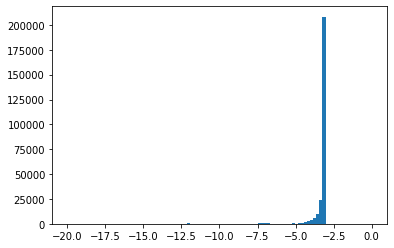

In [85]:
model_name = 'merged'
kde_results = collections.defaultdict(collections.defaultdict)
stats = collections.defaultdict(list)

predicts = []
ked_result_all = []
for bg_program in ['mysql', 'webserver', 'streamserver', 'mltrain', 'mapreduce']:
    for file_name in [
            'train_normal',
            'train_normal_with_gpg',
            'train_normal_with_gcc',
            'train_normal_with_mcf',
            'train_normal_with_libquantum',
            ]:

        kde_result = np.load(f'detector/preprocessed/kde/{model_name}/{bg_program}/{file_name}.npy')
        ked_result_all.append(kde_result)
        
ked_result_all = np.array(ked_result_all).reshape(-1)
ked_result_all.sort()

# Use the 10 percentile as threshold (10% of training normal is incorrectly classified as abnormal)
print("Mean ", np.mean(ked_result_all), "Std", np.std(ked_result_all))
plt.hist(ked_result_all, bins=np.linspace(-20, 0, 100))
print("Threshold ", np.percentile(ked_result_all, 20))

#### Try different thresholds / detection methods

In [83]:
import pandas as pd
pd.set_option('display.max_rows', None)

model_name = 'merged'
th = -3.3

kde_results = collections.defaultdict(collections.defaultdict)

predicts = []
for bg_program in ['mysql', 'webserver', 'streamserver', 'mltrain', 'mapreduce']: #'webserver'
    for file_name in [
            'test_normal',
            'test_normal_with_gpg',
            'test_normal_with_gcc',
            'test_normal_with_mcf',
            'test_normal_with_libquantum',
            'test_abnormal_l1pp',
            'test_abnormal_l3pp',
            'test_abnormal_fr',
            'test_abnormal_ff',
            'test_abnormal_spectrev1',
            'test_abnormal_spectrev2',
            'test_abnormal_spectrev3',
            'test_abnormal_spectrev4',
            'test_abnormal_bufferoverflow',
            'test_abnormal_l1pp_with_gpg',
            'test_abnormal_l3pp_with_gpg',
            'test_abnormal_fr_with_gpg',
            'test_abnormal_ff_with_gpg',
            'test_abnormal_spectrev1_with_gpg',
            'test_abnormal_spectrev2_with_gpg',
            'test_abnormal_spectrev3_with_gpg',
            'test_abnormal_spectrev4_with_gpg',
            'test_abnormal_bufferoverflow_with_gpg',
            'test_abnormal_l1pp_with_gcc',
            'test_abnormal_l3pp_with_gcc',
            'test_abnormal_fr_with_gcc',
            'test_abnormal_ff_with_gcc',
            'test_abnormal_spectrev1_with_gcc',
            'test_abnormal_spectrev2_with_gcc',
            'test_abnormal_spectrev3_with_gcc',
            'test_abnormal_spectrev4_with_gcc',
            'test_abnormal_bufferoverflow_with_gcc',
            'test_abnormal_l1pp_with_libquantum',
            'test_abnormal_l3pp_with_libquantum',
            'test_abnormal_fr_with_libquantum',
            'test_abnormal_ff_with_libquantum',
            'test_abnormal_spectrev1_with_libquantum',
            'test_abnormal_spectrev2_with_libquantum',
            'test_abnormal_spectrev3_with_libquantum',
            'test_abnormal_spectrev4_with_libquantum',
            'test_abnormal_bufferoverflow_with_libquantum',

            ]:

        kde_result = np.load(f'detector/preprocessed/kde/{model_name}/{bg_program}/{file_name}.npy')
        total = float(len(kde_result))
        
        pred_normal = np.sum(kde_result >= th) / total
        pred_abnormal = np.sum(kde_result < th) / total
        
        predicts.append([
            bg_program, file_name, pred_normal, pred_abnormal,
            np.mean(kde_result), np.std(kde_result), np.min(kde_result), np.max(kde_result),
            np.percentile(kde_result, 10), np.percentile(kde_result, 90)])

columns = ['Workload', 'Test Case', 'Pred normal', 'Pred abnormal', 'Mean', 'Std', 'Min', 'Max', '10%', '90%']
print(pd.DataFrame(predicts, columns=columns))

         Workload                                     Test Case  Pred normal  \
0           mysql                                   test_normal     0.999818   
1           mysql                          test_normal_with_gpg     0.999818   
2           mysql                          test_normal_with_gcc     0.381398   
3           mysql                          test_normal_with_mcf     0.255387   
4           mysql                   test_normal_with_libquantum     0.601236   
5           mysql                            test_abnormal_l1pp     0.000000   
6           mysql                            test_abnormal_l3pp     0.000000   
7           mysql                              test_abnormal_fr     0.000000   
8           mysql                              test_abnormal_ff     0.000000   
9           mysql                       test_abnormal_spectrev1     0.000000   
10          mysql                       test_abnormal_spectrev2     0.000000   
11          mysql                       